In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import moment
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt

order_of_polynom: int = 6

def find_coax_sens(df_calib: pd.DataFrame) -> float:
    df: pd.DataFrame = df_calib[3:]
    zenith_coax_angle: float = find_zenith_coax(df)
    zen_coax: float = np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'zen sens'].to_numpy())
    azim_coax: float = np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'azim sens'].to_numpy())
    return zen_coax, azim_coax

def define_aprox_coefs(df_calib: pd.DataFrame) -> list:
    '''Находим коэффициенты апроксимирующего полинома шестой степени из калибровочных данных'''
    df: pd.DataFrame = df_calib
    radius: list = df['radius sens'].to_numpy()
    thetta: list = df['zenith angle'].to_numpy()
    A: list = np.vstack([radius**i for i in range(order_of_polynom + 1)]).T
    coefficients: list = lsq_linear(A, thetta).x
    coefficients: list = [float('%.4e' % x) for x in coefficients]
    return coefficients

def define_aprox_polynom(df_calib: pd.DataFrame) -> np.poly1d:
    '''Находим полином шестой степени по коэффициентам'''
    df: pd.DataFrame = df_calib
    calib_coefs: list = define_aprox_coefs(df)
    calib_polynomial: np.poly1d = np.poly1d(np.flip(calib_coefs))
    return calib_polynomial

def find_angle_error(df_calib: pd.DataFrame) -> np.ndarray:
    '''Находим отклонение теоретических данных от экспериментальных'''
    df: pd.DataFrame = df_calib
    calib_polynom: np.poly1d = define_aprox_polynom(df)
    theor_data: np.ndarray = df['radius sens'].to_numpy()
    exp_dat: np.ndarray = df['zenith angle'].to_numpy()
    deviation_buff: np.ndarray = calib_polynom(theor_data) - exp_dat
    return deviation_buff

def plot_teor_exp_calib(df: pd.DataFrame) -> None:
    '''График экспериментальных данных с апроксимирующим полиномом 6 порядка'''
    calib_df: pd.DataFrame = df
    x_min: float = np.min(calib_df['radius sens'].to_numpy())
    x_max: float = np.max(calib_df['radius sens'].to_numpy())
    x_new: np.ndarray = np.arange(x_min, x_max)
    y_new: np.ndarray = define_aprox_polynom(calib_df)(x_new)

    x: np.ndarray = calib_df['radius sens'].to_numpy()
    y: np.ndarray = calib_df['zenith angle'].to_numpy()

    fig, ax = plt.subplots()
    ax.set_title('Зенитный угол датчика')
    ax.set_xlabel('Расстояние от центра, пикс.')
    ax.set_ylabel('Зенитный угол, град.')
    plt.grid(True)
    plt.plot(x_new, y_new, '-', x, y, '.')

    plt.show()

def plotZenithDeviation(df: pd.DataFrame) -> None:
    '''График отклонения экспериментального угла от теоретического'''
    calib_df: pd.DataFrame = df
    y_new: np.ndarray = find_angle_error(calib_df)
    y: np.ndarray = calib_df['zenith angle'].to_numpy()

    fig, ax = plt.subplots()
    plt.scatter(y, y_new, marker='o', c = 'r', s=15)
    plt.title('Отклонение зенитного угла')
    plt.ylim((-0.8, 0.8))
    plt.xlabel('Зенитный угол, град.')
    plt.ylabel('Отклонение зенитного угла, град.')
    plt.xticks(np.arange(0, 30, step=3))
    plt.yticks(np.arange(-0.8, 0.8, step=0.1))
    plt.grid(True)
    plt.show()

def find_matrix_dispersion(df_calib: pd.DataFrame | str) -> pd.DataFrame:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    zenith_df: pd.Series = df.loc[:, ['zenith angle']].drop_duplicates(ignore_index=True)
    radius_col: pd.DataFrame = df.loc[:, ['radius sens']]
    radius_col = radius_col.to_numpy().flatten()
    amount_unique_cells: int = len(zenith_df)
    number_azim_steps: int = len(radius_col) // amount_unique_cells
    dispersion_list: list = []
    dispersion: float = 0.0
    for i in range(amount_unique_cells):
        dispersion: float = round(float(moment(radius_col[i*number_azim_steps:(i+1)*number_azim_steps], 2)), 4)
        dispersion_list.append(dispersion)
    dispersion_list = np.array(dispersion_list)
    dispersion_df: pd.DataFrame = pd.DataFrame({'radius dispersion' : dispersion_list})
    dispersion_df = zenith_df.join(dispersion_df)
    result_df: pd.DataFrame = df.merge(dispersion_df, left_on='zenith angle', right_on='zenith angle')
    return result_df

def find_zen_angle_dispersion(df_calib: pd.DataFrame | str) -> np.ndarray:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    dispersion_order: int = 2
    digits: int = 4
    rows_num: int = df.index.stop
    zenith_steps_num: int = len(df.loc[:, 'zenith angle'].drop_duplicates())
    zenith_angle_exp: np.ndarray = df.loc[:, 'zen sens'].to_numpy()
    zenith_angle_thoer: np.ndarray = df.loc[:, 'zenith angle'].to_numpy()
    number_azim_steps: int = rows_num // zenith_steps_num
    zenith_dispersion: list = []
    for i in range(zenith_steps_num):
        err: list = abs(abs(zenith_angle_exp[i*number_azim_steps:(i+1)*number_azim_steps])
                            - abs(zenith_angle_thoer[i*number_azim_steps:(i+1)*number_azim_steps]))
        dispersion: float = round(float(moment(err, dispersion_order)), digits)
        zenith_dispersion.append(np.repeat(dispersion, number_azim_steps))
    zenith_dispersion = np.array(zenith_dispersion).flatten()
    return np.array(zenith_dispersion)


def find_zenith_coax(df_calib: pd.DataFrame | str) -> float:
    '''Находим соосное расположение ротатора по вертикальной оси'''
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    df: pd.DataFrame = find_matrix_dispersion(df)
    dispersion: np.ndarray = df['radius dispersion'].to_numpy()
    min_dev: float = np.min(dispersion)
    zenith_coax_angle: float = df.loc[df['radius dispersion'] == min_dev, 'zenith angle'].iloc[0]
    return zenith_coax_angle

def find_coax_x_y(df_calib: pd.DataFrame | str) -> float:
    '''Находим зенитный и азимутальный центр матрицы'''
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    zenith_coax_angle: float = find_zenith_coax(df)
    x_coax: float = round(np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'x sens'].to_numpy()), 4)
    y_coax: float = round(np.average(df.loc[df['zenith angle'] == zenith_coax_angle, 'y sens'].to_numpy()), 4)
    return x_coax, y_coax

def read_calib_from_csv(file_path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(file_path, sep='\t')
    return df

def get_coax_coords(df_calib: pd.DataFrame | str) -> dict:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    x, y = find_coax_x_y(df)
    center_coords_dict: dict = {
        'x coax' : x,
        'y coax' : y,
        'zenith coax' : find_zenith_coax(df)
    }
    return center_coords_dict

def plot_exp_angle_dispersion(df_calib: pd.DataFrame | str) -> None:
    if isinstance(df_calib, pd.DataFrame):
        df: pd.DataFrame = df_calib
    elif isinstance(df_calib, str):
        df: pd.DataFrame = read_calib_from_csv(df_calib)
    else:
        raise Exception("Wrong DataFrame type")
    theor_zen_angle: np.ndarray = df['zenith angle'].to_numpy()
    plt.scatter(theor_zen_angle, np.sqrt(find_zen_angle_dispersion(df_calib)), s=15)
    plt.grid(True)
    plt.xlabel('Угол поворота, град.')
    plt.ylabel('Среднеквадратичное отклонение угла')
    plt.title('Среднеквадратичное отклонение угла датчика')
    plt.show()

def prepare_calib_buffer(df_intensity: pd.DataFrame, df_normal: pd.DataFrame) -> np.ndarray:
    if isinstance(df_intensity, pd.DataFrame):
        df_intens: pd.DataFrame = df_intensity
    elif isinstance(df_intensity, str):
        df_intens: pd.DataFrame = read_calib_from_csv(df_intensity)
    else:
        raise Exception("Wrong DataFrame type")
    if isinstance(df_normal, pd.DataFrame):
        df_norm: pd.DataFrame = df_normal
    elif isinstance(df_normal, str):
        df_norm: pd.DataFrame = read_calib_from_csv(df_normal)
    else:
        raise Exception("Wrong DataFrame type")
    coefs: list = list(define_aprox_coefs(df_intens))
    coax_x_y: list = list(find_coax_x_y(df_norm))
    final_buffer: list = coefs + coax_x_y + [0.0] + [1.0] + [3.0]
    return final_buffer

df_intensity = pd.read_csv(r'D:\Python_projects\Calibrator\utils\Intensity_tables\01-12-2024_16-11-05_Intensity.csv', sep='\t')
df_normal: pd.DataFrame = pd.read_csv(r'D:\Python_projects\Calibrator\utils\Normal_fall\01-12-2024_16-03-53_Intensity.csv', sep='\t')

prepare_calib_buffer(df_intensity, df_normal)
# for x in a:
#     print('%.4e' % x)

In [123]:
df = read_calib_from_csv(r'D:\python_projects\Calibrator\utils\Angle_logs\01-12-2024_17-02-59_Velocity.csv')
time = df['time, sec'].to_numpy()
sensor_angle = df['sensor angle'].to_numpy()
rotator_anlge = df['rotator angle'].to_numpy()
sensor_angle[0:6] = -sensor_angle[0:6]

In [131]:
rotator_angle_speed = []
sensor_speed_delta = []
sensor_speed_deriv_1 = []
sensor_speed_deriv_2 = []

for i in range(2, len(rotator_anlge) - 2):
    rotator_angle_speed.append((rotator_anlge[i] - rotator_anlge[i-1]) / (time[i] - time[i-1]))
    sensor_speed_delta.append(abs(sensor_angle[i] - sensor_angle[i-1]) / (time[i] - time[i-1]))
    sensor_speed_deriv_1.append(abs(sensor_angle[i + 1] - sensor_angle[i-1]) / (2*(time[i] - time[i-1])))
    sensor_speed_deriv_2.append(abs(sensor_angle[i - 2] - 8*sensor_angle[i-1] + 8*sensor_angle[i+1] - sensor_angle[i+2]) / (12*(time[i] - time[i-1])))

In [138]:
delta_time: list = [time[i] - time[i-1] for i in range(2, len(rotator_anlge) - 2)]

In [139]:
time_list: list = []
for i, delta in enumerate(delta_time):
    if i == 0:
        time_list.append(delta)
    else:
        time_list.append(time_list[i-1] + delta)

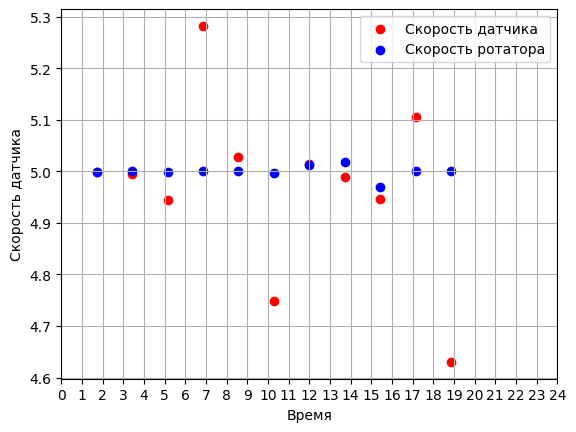

In [141]:
ax_sensor = plt.scatter(time_list, sensor_speed_deriv_2, c='r')
ax_rotator = plt.scatter(time_list, rotator_angle_speed, c='b')
plt.legend((ax_sensor, ax_rotator), ['Скорость датчика', 'Скорость ротатора'])
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Скорость датчика')
plt.xticks(np.arange(0, 25, 1))
plt.show()

In [156]:
sensor_speed_delta_bias = (np.array(sensor_speed_delta) - np.array(rotator_angle_speed))**2
sensor_speed_deriv_1_bias = (np.array(sensor_speed_deriv_1) - np.array(rotator_angle_speed))**2
sensor_speed_deriv_2_bias = (np.array(sensor_speed_deriv_2) - np.array(rotator_angle_speed))**2

In [153]:
sensor_speed_delta_var = np.var(sensor_speed_delta_bias)
sensor_speed_deriv_1_var = np.var(sensor_speed_deriv_1_bias)
sensor_speed_deriv_2_var = np.var(sensor_speed_deriv_2_bias)

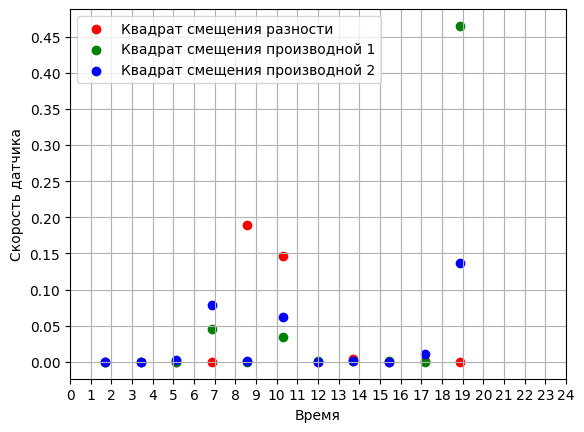

In [164]:
ax_delta = plt.scatter(time_list, sensor_speed_delta_bias, c='r')
ax_deriv_1 = plt.scatter(time_list, sensor_speed_deriv_1_bias, c='g')
ax_deriv_2 = plt.scatter(time_list, sensor_speed_deriv_2_bias, c='b')
plt.legend((ax_delta, ax_deriv_1, ax_deriv_2), ['Квадрат смещения разности', 'Квадрат смещения производной 1', 'Квадрат смещения производной 2'])
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Скорость датчика')
plt.xticks(np.arange(0, 25, 1))
plt.yticks(np.arange(0, 0.5, 0.05))
plt.show()